<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
!pip install numpy==1.26.4
import numpy as np
np.__version__

'1.26.4'

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
import numpy as np

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip3 install torchinfo
from torchinfo import summary

In [ ]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [ ]:
def sequence_acc(y_pred, y_test):
    # Aseguramos que ambos estén en el mismo device
    device = y_pred.device
    y_test = y_test.to(device)

    y_pred_tag = y_pred.data.max(dim=-1, keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1, keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    # IMPORTANTE: crear batch_acc en el mismo device
    batch_acc = torch.zeros(batch_size, device=device)

    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Listas para graficar resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        # ---------- ENTRENAMIENTO ----------
        for train_encoder_input, train_decoder_input, train_target in train_loader:
            optimizer.zero_grad()

            # Enviar TODO al mismo device
            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            output = model(train_encoder_input, train_decoder_input)

            # sequence loss (por token)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                target_t = train_target[:, t, :].argmax(dim=1)  # (batch,)
                loss += criterion(output[:, t, :], target_t)

            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # ---------- VALIDACIÓN ----------
        with torch.no_grad():
            valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))

            valid_encoder_input = valid_encoder_input.to(device)
            valid_decoder_input = valid_decoder_input.to(device)
            valid_target = valid_target.to(device)

            output = model(valid_encoder_input, valid_decoder_input)

            epoch_valid_loss = 0
            for t in range(valid_decoder_input.shape[1]):
                target_t = valid_target[:, t, :].argmax(dim=1)
                epoch_valid_loss += criterion(output[:, t, :], target_t)

            epoch_valid_loss = epoch_valid_loss.item()
            valid_loss.append(epoch_valid_loss)

            epoch_valid_accuracy = sequence_acc(output, valid_target).item()
            valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - "
              f"Train loss {epoch_train_loss:.3f} - "
              f"Train accuracy {epoch_train_accuracy:.3f} - "
              f"Valid Loss {epoch_valid_loss:.3f} - "
              f"Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history


### 1 - Datos

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 20000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 20000


In [ ]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [ ]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [ ]:
# Longitudes máximas “deseadas”
MAX_INPUT_LEN = 26   # antes 16
MAX_OUT_LEN   = 28   # antes 18

from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = min(MAX_INPUT_LEN, max(len(sen) for sen in input_integer_seq))
print("Longitud máxima entrada usada:", max_input_len)

Palabras en el vocabulario: 6820
Longitud máxima entrada usada: 26


In [ ]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
idx2word_target = {idx: word for word, idx in word2idx_outputs.items()}

max_out_len   = min(MAX_OUT_LEN,   max(len(sen) for sen in output_integer_seq))
print("Longitud máxima salida usada:", max_out_len)

Palabras en el vocabulario: 11262
Longitud máxima salida usada: 28


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [ ]:
max_input_len = 16
max_out_len = 18

In [ ]:
from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 20000
encoder_input_sequences shape: (20000, 16)
decoder_input_sequences shape: (20000, 18)


In [ ]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (20000, 18)


In [ ]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([20000, 18])

In [ ]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 18
Output dim 8000


In [ ]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 16000
Tamaño del conjunto de validacion: 4000


### 3 - Preparar los embeddings

In [ ]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
From (redirected): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download&confirm=t&uuid=f79de2aa-a2dc-4be2-a8c5-c13d361772ab
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:10<00:00, 49.5MB/s]


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

Implementación beam search

In [ ]:
import math

def beam_search_decode(model, encoder_seq, beam_width=3, max_len=None):
    """
    Decodificación con beam search.
    encoder_seq: np.array (1, max_input_len) o tensor
    beam_width: tamaño del haz
    max_len: longitud máxima de secuencia generada
    """
    if max_len is None:
        max_len = max_out_len

    # A tensor + device
    if isinstance(encoder_seq, np.ndarray):
        encoder_seq = torch.from_numpy(encoder_seq.astype(np.int64))
    encoder_seq = encoder_seq.to(device)

    model.eval()
    with torch.no_grad():
        # Paso por el encoder
        prev_state = model.encoder(encoder_seq)

        sos = word2idx_outputs['<sos>']
        eos = word2idx_outputs['<eos>']

        # Cada beam = (log_prob_acumulada, [tokens_ids], prev_state, last_token_tensor)
        start_token = torch.tensor([[sos]], device=device)
        beams = [(0.0, [sos], prev_state, start_token)]
        completed = []

        for _ in range(max_len):
            new_beams = []

            for log_p, seq, state, last_token in beams:
                # Si ya llegó a <eos>, lo pasamos a completados
                if seq[-1] == eos:
                    completed.append((log_p, seq))
                    continue

                # Decoder un paso
                out, new_state = model.decoder(last_token, state)  # out: (1, vocab)
                # Trabajamos en log-prob
                log_probs = torch.log(out.squeeze(0) + 1e-12)      # (vocab,)
                topk_log_probs, topk_idx = torch.topk(log_probs, beam_width)

                for k in range(beam_width):
                    idx = int(topk_idx[k].item())
                    new_log_p = log_p + float(topk_log_probs[k].item())
                    new_seq = seq + [idx]
                    new_token = torch.tensor([[idx]], device=device)
                    new_beams.append((new_log_p, new_seq, new_state, new_token))

            if not new_beams:
                break

            # Nos quedamos con los mejores beam_width
            new_beams.sort(key=lambda x: x[0], reverse=True)
            beams = new_beams[:beam_width]

        # Añadimos lo que haya quedado vivo
        completed += beams
        completed.sort(key=lambda x: x[0], reverse=True)
        best_seq = completed[0][1]

        # Convertimos ids → palabras (salteando <sos> y <eos>)
        sos = word2idx_outputs['<sos>']
        eos = word2idx_outputs['<eos>']

        words = []
        for idx in best_seq:
            if idx in (sos, eos):
                continue
            if idx > 0 and idx in idx2word_target:
                words.append(idx2word_target[idx])

        return ' '.join(words)


In [ ]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 79


In [ ]:
nb_words

6820

In [ ]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(6820, 50)

### 4 - Entrenar el modelo

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, lstm_size=128, num_layers=1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # congelar embeddings

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers
        )

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, lstm_size=128, num_layers=1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.fc1 = nn.Linear(in_features=self.lstm_size,
                             out_features=self.output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:, -1, :]))  # último paso temporal
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input_data, decoder_input_data):

        # Aseguramos que TODO esté en el mismo device que el modelo
        device = next(self.parameters()).device
        encoder_input_data = encoder_input_data.to(device)
        decoder_input_data = decoder_input_data.to(device)

        # Encoder
        encoder_last_state = self.encoder(encoder_input_data)

        # Decoder (teacher forcing)
        outputs = []
        prev_state = encoder_last_state

        for t in range(decoder_input_data.size(1)):
            # tomamos el token t
            dec_input_t = decoder_input_data[:, t].unsqueeze(1)
            out, prev_state = self.decoder(dec_input_t, prev_state)
            outputs.append(out.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 18, 8000]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 16, 50]               341,000
│    └─LSTM: 2-2                         [1, 16, 128]              92,160
├─Decoder: 1-2                           [1, 8000]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                400,000
│    └─LSTM: 2-4                         [1, 1, 128]               92,160
│    └─Linear: 2-5                       [1, 8000]                 1,032,000
│    └─Softmax: 2-6                      [1, 8000]                 --
├─Decoder: 1-3                           [1, 8000]                 (recursive)
│    └─Embedding: 2-7                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─Linear: 2-9               

In [ ]:
hidden_sizes = [256]
histories = {}

for h in hidden_sizes:
    print(f"\n>>> Entrenando modelo con {h} neuronas LSTM")

    encoder = Encoder(vocab_size=nb_words, lstm_size=h)
    decoder = Decoder(vocab_size=num_words_output,
                      output_dim=num_words_output,
                      lstm_size=h)

    if cuda:
        encoder.cuda()
        decoder.cuda()

    model = Seq2Seq(encoder, decoder).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    history = train(
        model,
        train_loader,
        valid_loader,
        optimizer,
        criterion,
        epochs=35
    )

    histories[h] = history





>>> Entrenando modelo con 256 neuronas LSTM
Epoch: 1/35 - Train loss 151.409 - Train accuracy 0.609 - Valid Loss 150.181 - Valid accuracy 0.644
Epoch: 2/35 - Train loss 150.721 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 3/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 4/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 5/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 6/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 7/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 8/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 9/35 - Train loss 150.720 - Train accuracy 0.614 - Valid Loss 150.180 - Valid accuracy 0.644
Epoch: 10/35 - Train loss 150.660 - Train accuracy 0.61

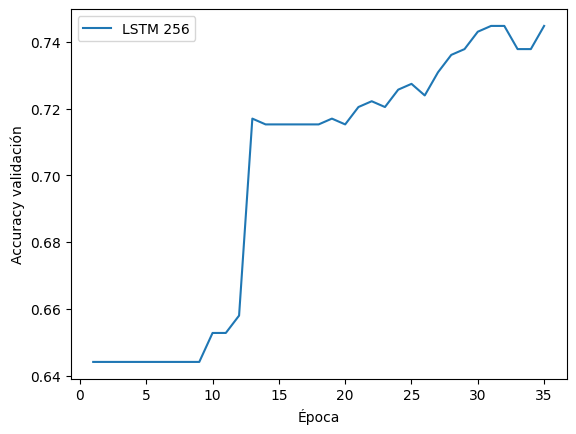

In [ ]:
epoch_count = range(1, len(next(iter(histories.values()))['accuracy']) + 1)

for h, hist in histories.items():
    sns.lineplot(x=epoch_count, y=hist['val_accuracy'], label=f'LSTM {h}')

plt.xlabel('Época')
plt.ylabel('Accuracy validación')
plt.legend()
plt.show()


**Mostrar 5 ejemplos de traducciones generadas**

In [ ]:
def translate_sentence(input_seq, mode="greedy", beam_width=3):
    """
    input_seq: np.array (1, max_input_len) o tensor
    mode: "greedy" o "beam"
    """
    if mode == "beam":
        return beam_search_decode(model, input_seq, beam_width=beam_width)

    # --- modo GREEDY (el que ya tenías) ---
    if isinstance(input_seq, np.ndarray):
        encoder_seq = torch.from_numpy(input_seq.astype(np.int64))
    else:
        encoder_seq = input_seq

    encoder_seq = encoder_seq.to(device)

    model.eval()
    with torch.no_grad():
        prev_state = model.encoder(encoder_seq)

        target_seq = np.zeros((1, 1), dtype='int32')
        target_seq[0, 0] = word2idx_outputs['<sos>']
        target_seq_tensor = torch.from_numpy(target_seq).to(device)

        eos = word2idx_outputs['<eos>']
        output_sentence = []

        for _ in range(max_out_len):
            output, prev_state = model.decoder(target_seq_tensor, prev_state)
            top1 = output.argmax(1).view(-1, 1)
            idx = int(top1.item())

            if idx == eos:
                break

            if idx > 0 and idx in idx2word_target:
                word = idx2word_target[idx]
                output_sentence.append(word)

            target_seq_tensor = top1

    return ' '.join(output_sentence)


Visualizar los 5 ejemplos (aleatorios)

In [ ]:
def show_random_examples(n=5, mode="greedy", beam_width=3):
    for _ in range(n):
        i = np.random.choice(len(input_sentences))
        input_text = input_sentences[i]
        target_text = output_sentences[i]

        input_seq = encoder_input_sequences[i:i+1]

        translation = translate_sentence(input_seq, mode=mode, beam_width=beam_width)

        print('-' * 60)
        print(f'Input      : {input_text}')
        print(f'Target     : {target_text}')
        print(f'Predicción : {translation}')




In [ ]:
model.eval()
show_random_examples(5, mode="greedy")
show_random_examples(5, mode="beam", beam_width=5)

------------------------------------------------------------
Input      : Your work has greatly improved.
Target     : Tu trabajo ha mejorado notablemente. <eos>
Predicción : es un
------------------------------------------------------------
Input      : Tom is naked.
Target     : Tom anda encuerado. <eos>
Predicción : tom es un
------------------------------------------------------------
Input      : I can't hear you.
Target     : No puedo oírte. <eos>
Predicción : no es un
------------------------------------------------------------
Input      : She seemed to be suffering a heart attack.
Target     : Ella parecía estar sufriendo un ataque al corazón. <eos>
Predicción : a la de la
------------------------------------------------------------
Input      : Don't pretend what you don't feel.
Target     : ¡No finja usted lo que no siente! <eos>
Predicción : no es que no es un
------------------------------------------------------------
Input      : He is in good physical condition.
Target 

#**Conclusiones**

Más allá que de haber implementado greedy y beam search (utiluzando LSTM de 256 neuronas) no hubo buen resultado de traducción. Inclusive con una ligeramente mejor accuracy resultando en un mejor entrenamiento con las palabras, no mejoró la capacidad de predecir en base al contexto. Como trabajo futuro se propone la implementación de algun modelo con atención.  